# Light example: generate influence diagram

- 1 light + 1 switch
- normal operation and so highest chance: light is on and switch set to on
- both components have a health variable
- light 1 can be tested with 2 tests
  - test 1 is cheapest test
  - test 2 is more expensive
- when test 2 negative then replace component
- switch can be tested with 1 test 
- 

this notebook generates the influence diagram

In [1]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML

In [2]:
# create influence diagram
diag = gum.InfluenceDiagram()

# influence diagram structure

chance, decision and utility variables

CL1: light 1 
- normal behavior is light 1 is on 
- but can also be off

HL1: light 1 health 
- models if light is broken. 
- If HL1 set to broken light 1 will be off. 
- So light 1 is conditionally dependent on L1H

In [3]:
# CL1 and HL1
CL1 = diag.addChanceNode(gum.LabelizedVariable('CL1', 'L1 component', ["on", "off"]))
HL1 = diag.addChanceNode(gum.LabelizedVariable('HL1', 'L1 health', ["ok", "broken"]))

# CL1 is conditionally dependent on L1H
diag.addArc(HL1, CL1)

DT1: test 1
- decision variable test 1 determines if test 1 will be performed
- values are yes / no
- if HL1 is likely broken DT1 becomes relevant

RT1: test result of test 1
- chance variable test 1 result models outcome of test 1: OK, not OK
- not done is also an option if DT1 set to no

UT1: utility of test 1
- function of L1H and DT1 
- when low health it's likely to perform test for more assurance

In [4]:
DT1 = diag.addDecisionNode(gum.LabelizedVariable('DT1', 'Decide T1', ["yes", "no"]))
RT1 = diag.addChanceNode(gum.LabelizedVariable('RT1', 'Result T1', ["not done", "ok", "broken"]))
UT1 = diag.addUtilityNode(gum.LabelizedVariable("UT1", "R(L1H, DT1)", 1))

In [5]:
diag.addArc(DT1, UT1)
diag.addArc(HL1, RT1)
diag.addArc(HL1, UT1)

DT2 test 2
- decision variable test 2 determines if test 2 will be performed
- values are yes / no
- if RT1 is likely broken DT1 becomes relevant

RT2: test result of test 2
- chance variable test 2 result models outcome of test 2: OK, not OK
- not done is also an option if DT2 set to no

UT2: utility of test 1
- function of RT1 and DT2 
- when low health it's likely to perform test for more assurance

In [6]:
DT2 = diag.addDecisionNode(gum.LabelizedVariable('DT2', 'Decide T2', ["yes", "no"]))
RT2 = diag.addChanceNode(gum.LabelizedVariable('RT2', 'Result T2', ["not done", "ok", "broken"]))
UT2 = diag.addUtilityNode(gum.LabelizedVariable("UT2", "R(RT1, DT2)", 1))

In [7]:
diag.addArc(DT2, UT2)
diag.addArc(RT1, RT2)
diag.addArc(RT1, UT2)

DRL1, decision to replace light 1
- decision variable DRL1 to decide if light 1 needs replacing
- values are replace / keep
- if RT2 is likely broken DRL1 becomes relevant

URL1: utility for replacing light 1
- function of RT2 and DRL1 
- when low health it's likely to perform test for more assurance

In [8]:
DRL1 = diag.addDecisionNode(gum.LabelizedVariable('DRL1', 'replace Light 1 T2', ["replace", "keep"]))
URL1 = diag.addUtilityNode(gum.LabelizedVariable("URL1", "R(RT2, DRL1)", 1))

In [9]:
diag.addArc(DRL1, URL1)
diag.addArc(RT2, URL1)

Influence Diagram{
  chance: 4,
  utility: 3,
  decision: 3,
  arcs: 9,
  domainSize: 288
}


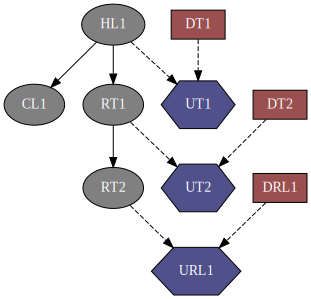

In [10]:
print(diag)
gnb.showInfluenceDiagram(diag, size=60)

# probabilities

In [11]:
# CL1 and HL1
diag.cpt(CL1)[{"HL1":0}] = [0.95, 0.05]  # when S1:on, HL1: healthy > CL1 should be on
diag.cpt(CL1)[{"HL1":1}] = [0.1, 0.9]  # when S1:on, HL1: broken > CL1 likely off

diag.cpt(HL1)[0] = 0.7  # most likely light is not broken
diag.cpt(HL1)[1] = 0.3  # but 30% chance light is broken

In [12]:
# RT1
diag.cpt(RT1)[{"HL1": "ok"}]          = [0.95, 0.05, 0.0]  # HL1:ok > RT1 likely not done
diag.cpt(RT1)[{"HL1": "broken"}]      = [0.4, 0.1, 0.5]  # HL1:broken > RT1 likely broken

In [13]:
# RT2
diag.cpt(RT2)[{"RT1": "not done"}]    = [0.95, 0.05, 0.0]   # RT1:not done > RT2 likely not done
diag.cpt(RT2)[{"RT1": "ok"}]          = [0.05, 0.90, 0.05]  # RT1:ok > RT2 likely OK
diag.cpt(RT2)[{"RT1": "broken"}]      = [0.4, 0.1, 0.5]   # RT1:broken > RT2 likely broken or not done

In [14]:
gnb.flow.row(diag.cpt(CL1),
            diag.cpt(HL1),
            diag.cpt(RT1),
            diag.cpt(RT2),
            captions=[  "prior of CL1",
                        "prior of HL1",
                        "prior of RT1",
                        "prior of RT2"
                      ])

# utility function

In [15]:
diag.utility("UT1")[{"HL1":"ok", "DT1": "yes"}]           = 1   # test done but not relevant
diag.utility("UT1")[{"HL1":"broken", "DT1": "yes"}]       = 3   # test done when broken, excellent
diag.utility("UT1")[{"HL1":"ok", "DT1": "no"}]            = 2   # test not done but that's ok
diag.utility("UT1")[{"HL1":"broken", "DT1": "no"}]        = 0   # test not done when broken: missed chance

In [16]:
diag.utility("UT2")[{"RT1":"not done", "DT2": "yes"}]     = 1   # test done but not relevant
diag.utility("UT2")[{"RT1":"ok", "DT2": "yes"}]           = 0   # test done but not relevant
diag.utility("UT2")[{"RT1":"broken", "DT2": "yes"}]       = 3   # test done when broken, excellent
diag.utility("UT2")[{"RT1":"not done", "DT2": "no"}]      = 2   # test not done but not relevant
diag.utility("UT2")[{"RT1":"ok", "DT2": "no"}]            = 3   # test not done but that's ok
diag.utility("UT2")[{"RT1":"broken", "DT2": "no"}]        = 2   # test not done when broken: missed chance


In [17]:
diag.utility("URL1")[{"RT2":"not done", "DRL1": "replace"}]    = 2   # test done but not relevant
diag.utility("URL1")[{"RT2":"not done", "DRL1": "keep"}]       = 4   # test not done but that's ok
diag.utility("URL1")[{"RT2":"ok", "DRL1": "replace"}]          = 0   # test done but not relevant
diag.utility("URL1")[{"RT2":"ok", "DRL1": "keep"}]             = 3   # test not done but that's ok
diag.utility("URL1")[{"RT2":"broken", "DRL1": "replace"}]      = 4   # test done when broken, excellent
diag.utility("URL1")[{"RT2":"broken", "DRL1": "keep"}]         = 4   # test not done when broken: missed chance

In [18]:
gnb.flow.row(diag.utility("UT1"),
            diag.utility("UT2"),
            diag.utility("URL1"),
           
            captions=[  "utility UT1",
                        "utility UT2",
                        "utility URL1",
            
                      ])

In [ ]:
diag.saveBIFXML("lightv4.xml")